**Option Pricing via FFT Techniques The Heston Model is defined by the following system of stochastic differential equations:**
$$dS_{t}=rS_{t}dt+\sqrt{v_{t}}S_{t}dW_{t}^{1} $$
$$dv_{t}=\kappa(\theta-v_{t})dt+\sigma\sqrt{v_{t}}dW_{t}^{2}$$
$$Cov(dW_{t}^{1}, dW_{t}^{2})=\rho dt $$
**The characteristic function for the Heston Model is known to be:**
$$w(u)=\frac{exp(iuln(S_{0}))+iu(r-q)t+\frac{\kappa\theta t(\kappa-i\rho\sigma u)}{\sigma^{2}}}{(cosh(\frac{\lambda t}{2})+\frac{\kappa-i\rho\sigma u}{\lambda}sinh(\frac{\lambda t}{2}))^{\frac{2\kappa\theta}{\sigma^{2}}}} $$
$$\Psi(u)=w(u)exp(\frac{-(u^{2}+iu)v_{0}}{\lambda coth(\frac{\lambda t}{2})+\kappa-i\rho\sigma u}) $$
$$\lambda = \sqrt{\sigma^{2}(u^{2}+iu)+(\kappa-i\rho\sigma u)^{2}} $$
**Assume the risk-free rate is 2%, the initial asset price is 250 and that the asset pays no dividends.**

(a) Exploring FFT Technique Parameters Consider a European Call Option with strike 250 expiring in six months. Additionally, assume you know that the parameters of the Heston Model are:

In [194]:
import numpy as np
import scipy.stats as stats
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [195]:
class FFT:
    def __init__(self, sigma, eta0, kappa, rho, theta, S0, r, T):
        self.sigma = sigma
        self.eta0 = eta0
        self.kappa = kappa
        self.rho = rho
        self.theta = theta
        self.S0 = S0
        self.r = r
        self.T = T
    
    def Heston_cf(self, u): 
        """Heston model characteristic function """
        i = complex(0,1)
        lam = np.sqrt(self.sigma**2*(u**2+i*u)+(self.kappa-i*self.rho*self.sigma*u)**2)
        w = np.exp(i*u*np.log(self.S0)+i*u*(self.r-0)*self.T+self.kappa*self.theta*self.T*\
        (self.kappa-i*self.rho*self.sigma*u)/self.sigma**2)/(np.cosh(lam*self.T/2)+(self.kappa-\
        i*self.rho*self.sigma*u)/lam*np.sinh(lam*self.T/2))**(2*self.kappa*self.theta/self.sigma**2)
        Psi = w*np.exp(-(u**2+i*u)*eta0/(lam/np.tanh(lam*self.T/2)+self.kappa-i*self.rho*self.sigma*u))
        return Psi

    def dirac(self, n):
        """define a dirac delta function"""
        y = np.zeros(len(n), dtype = complex)
        y[n==0] = 1
        return y

    def Heston_fft(self, alpha, n, upper_bound, K):
        t = time.process_time()
        N = 2 ** n
        delta_v = upper_bound / N
        delta_k = 2 * np.pi / N / delta_v

        J = m = np.arange(1, N+1, dtype = complex)

        Beta = np.log(self.S0) - delta_k * N / 2
        km = Beta + (m-1) * delta_k
        vj = (J-1) * delta_v #[nodes]
        i = complex(0,1)

        Psi_v = np.zeros(len(J), dtype = complex)
        for ii in range(N):
            u = vj[ii] - (alpha + 1) * i
            Psi_v[ii] = self.Heston_cf(u) / ((alpha + vj[ii] * i) * (alpha + 1 + vj[ii] * i))

        # compute FFT
        xj = (delta_v/2) * Psi_v * np.exp(-i * Beta * vj) * (2 - self.dirac(J-1))
        yj = np.fft.fft(xj)        
        
        # calculate option price
        CT_kj = np.exp(-alpha * np.array(km)) / np.pi * np.array(yj).real
        k_List = list(Beta + (np.cumsum(np.ones((N, 1))) - 1) * delta_k)
        Kt = np.exp(np.array(k_List)) # Real strike price K
        return np.exp(-self.r * self.T) * interpolate.splev(K, interpolate.splrep(Kt, np.real(CT_kj))).real, time.process_time() - t
    
    def alpha(self, lst, n, B, K):
        
        yy = np.array([self.Heston_fft(a, n, B, K)[0] for a in lst])
        fig, ax = plt.subplots(figsize = (20, 10))
        ax.plot(lst, yy)
        ax.set_xlabel("Alpha")
        ax.set_ylabel("Price")
        plt.show()

    # (a) ii
    def Optimize_N_B(self, n_list, B_list, K):
        Z = np.zeros((len(n_list),len(B_list)))
        E = np.zeros((len(n_list),len(B_list)))
        cc = []
        X, Y = np.meshgrid(n_list, B_list)
        for i in range(len(n_list)):
            for j in range(len(B_list)):
                temp = self.Heston_fft(1,n_list[i],B_list[j],K)
                Z[i][j] = temp[0]
                E[i][j] = 1/((temp[0]-21.27)**2*temp[1])
                cc += [(E[i][j],n_list[i],B_list[j])]

        print(max(cc))
        fig = plt.figure()
        ax1 = Axes3D(fig)
        ax1.plot_surface(X, Y, Z.T, rstride = 1, cstride = 1, cmap = 'magma')
        plt.title("Heston model European Call Price vs N and B")
        ax1.set_xlabel("N")
        ax1.set_ylabel("B")
        ax1.set_zlabel("European Call Price")
        plt.show()
        
        fig = plt.figure()
        ax2 = Axes3D(fig)
        ax2.plot_surface(X, Y, E.T, rstride = 1, cstride = 1, cmap = 'magma')
        plt.title("Efficiency vs N and B")
        ax2.set_xlabel("N")
        ax2.set_ylabel("B")
        ax2.set_zlabel("Efficiency")
        plt.show()

In [196]:
alpha = 1.5
sigma = 0.2
eta0 = 0.08
kappa = 0.7
rho = -0.4
theta = 0.1
S0 = 250
K = 250
r = 0.02
T = 0.5
n = 11
upper_bound = 250 * 2.7
Call = FFT(sigma, eta0, kappa, rho, theta, S0, r, T)

In [197]:
[Call.Heston_fft(i, n, upper_bound, K)[0] for i in [0.001, 0.01, 0.5, 1, 1.5, 5, 10, 15, 20, 35, 40]]

[13010.629229321856,
 1211.6343769220348,
 21.286995324024662,
 21.26886852639592,
 21.268867212168068,
 21.26886721207282,
 21.268867212072927,
 21.268867212072742,
 21.26886721207331,
 21.274960796075682,
 2.37949464688012e+17]

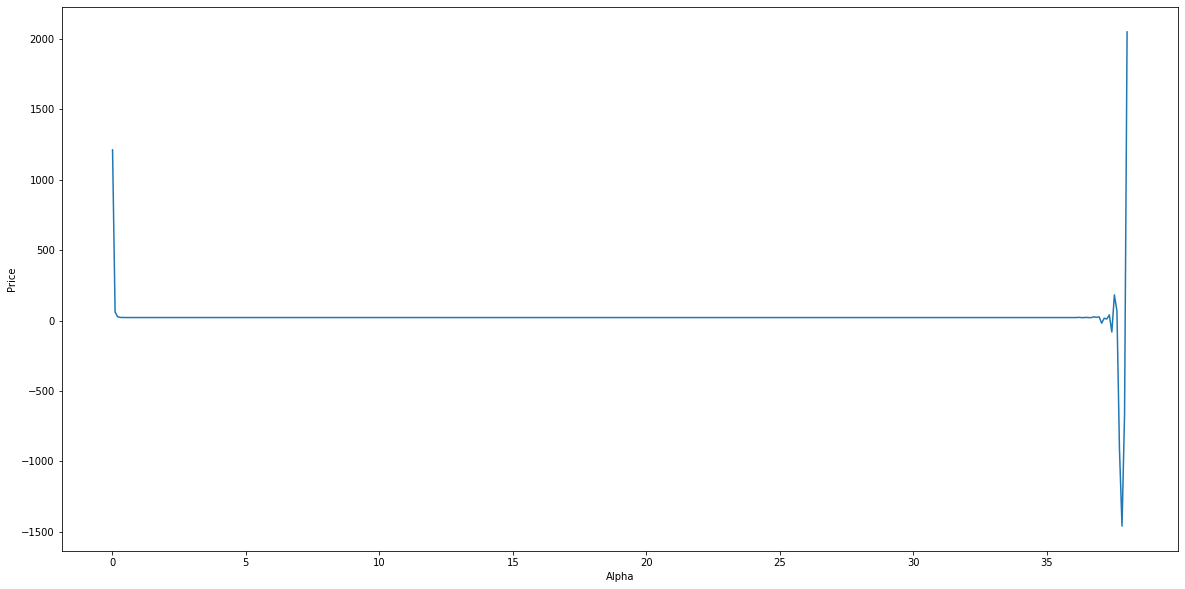

In [198]:
# (a)i
alphas = np.linspace(0.01, 38, num = 400)
Call.alpha(alphas, n, upper_bound, K)

- ## From the plot above, $\alpha$ is better to be in [1, 35] so that the price of European Call option is stable.
- ## For later use, I set alpha to be 1.5

In [199]:
B_list = np.linspace(250 * 2.5, 250 * 2.7, 100)
n_list = np.array([7, 8, 9, 10, 11, 12, 13, 14])

(13337617.135102753, 11, 627.5252525252525)


<ipython-input-195-d43d52abf896>:80: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(fig)
<ipython-input-195-d43d52abf896>:89: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax2 = Axes3D(fig)


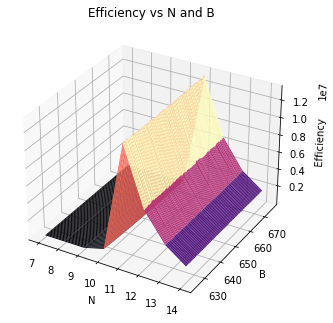

In [200]:
Call.Optimize_N_B(n_list, B_list, K)

- ## When $n\in [9, 13]$ and $B\in[630, 670]$, price is stable and accurate. From the second graph, efficiency is the highest when n is around 11. Also, as B changes, the efficiency doesn't change, so we can choose any $B\in[630, 670$. To be more efficient and safe computation power, I print out the best combination which is B = 627 with n = 11.

(11.693754869385616, 9, 674.4949494949495)


<ipython-input-195-d43d52abf896>:80: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax1 = Axes3D(fig)
<ipython-input-195-d43d52abf896>:89: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax2 = Axes3D(fig)


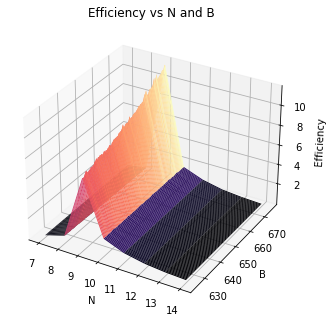

In [201]:
Call.Optimize_N_B(n_list, B_list, 260)

- ## When $n\in [9, 13]$ and $B\in[630, 670]$, price is stable and accurate. This European call price graph is almost the same as the previous one.
- ## The efficiency graph is a bit different. As B increases, efficiency increases. N should be around 9 to get the highest efficiency. Thus the best combination printed out is B = 675 with n = 9.

In [211]:
from scipy.optimize import root

def CallPrice(sigma, T, r, K, S_0):        
    d1 = (np.log(S_0 / K) +  ((r + 0.5 * sigma ** 2) * T)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return stats.norm.cdf(d1, 0, 1) * S_0 - stats.norm.cdf(d2, 0, 1) * K * np.exp(-r * T)   

def vol_K(price_list, K_list, sigma, T, r, S_0):
    vol = [root(lambda x: CallPrice(x, T, r, K_list[i], S_0) - price_list[i], 0.4).x for i in range(len(K_list))]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
    ax1.plot(K_list, price_list)
    ax1.set_xlabel("Strike Price K")
    ax1.set_ylabel("FFT Call Price")
    ax2.plot(K_list, vol)
    ax2.set_xlabel("Strike Price K")
    ax2.set_ylabel("Implied Volatility")

def vol_T(price_list, t_list, sigma, r, K, S_0):
    vol = [root(lambda x: CallPrice(x, t_list[i], r, K, S_0) - price_list[i], 0.2).x for i in range(len(t_list))]    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

    ax1.plot(t_list, price_list)
    ax1.set_xlabel("Expiry T")
    ax1.set_ylabel("FFT Call Price")
    ax2.plot(t_list, vol)
    ax2.set_xlabel("Expiry T")
    ax2.set_ylabel("Implied Volatility")

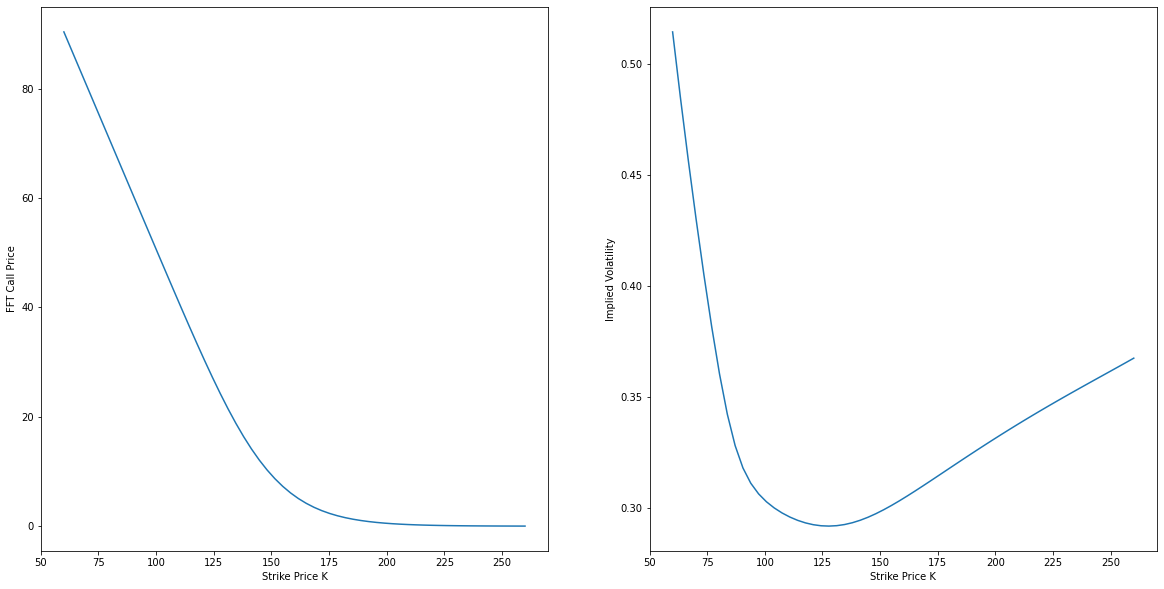

In [212]:
alpha = 1.5
sigma = 0.4
eta0 = 0.09
kappa = 0.5
rho = 0.25
theta = 0.12
K = 150
T = 0.25
r = 0.025
S0 = 150
n = 9
B = 150 * 2.7

Call_b = FFT(sigma, eta0, kappa, rho, theta, S0, r, T)
K_list = np.linspace(60, 260, 60)
b_price = [Call_b.Heston_fft(alpha, n, B, j)[0] for j in K_list]
vol_K(b_price, K_list, sigma, T, r, S0)

## Above is Implied Volatility vs. Strike Price K and Call Price vs. Strike Price K

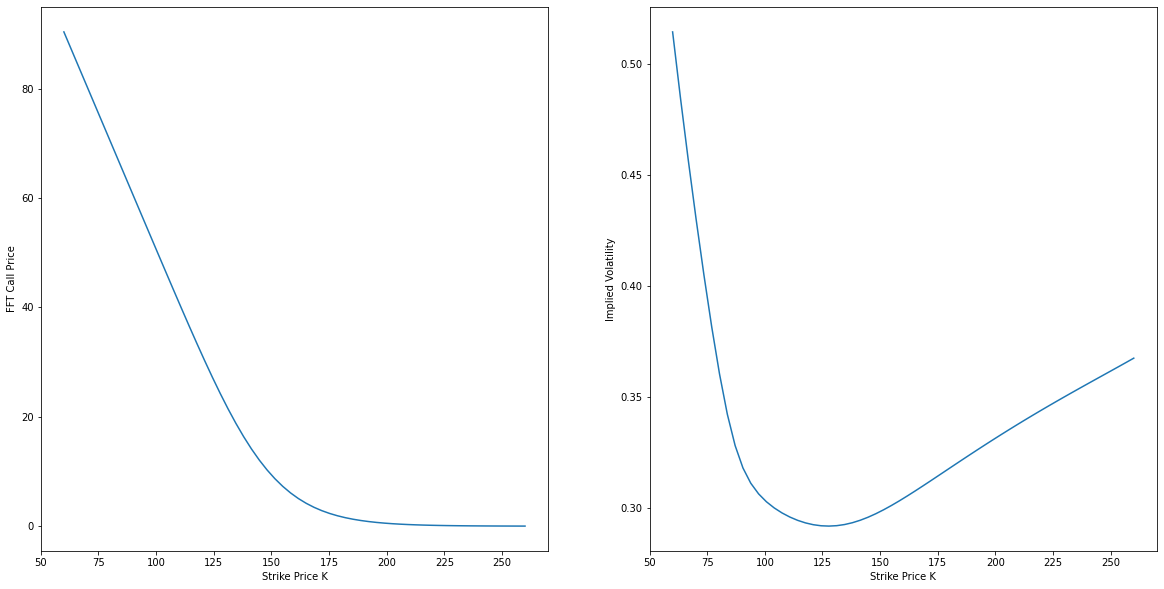

In [204]:
T_list = np.linspace(1/12, 2, 50)
price_list = [FFT(sigma, eta0, kappa, rho, theta, S0, r, t).Heston_fft(alpha, n, B, K)[0] for t in T_list]
vol_T(price_list, T_list, sigma, r, K, S0)
vol_K(b_price, K_list, sigma, T, r, S0)

## Above is Implied Volatility vs. Strike Price K, Call Price vs. Strike Price K
## And Implied Volatility vs. Expiry T, Call Price vs. Expiry T

## sigma = 0.4 eta0 = 0.09 kappa = 0.5 rho = 0.25 theta = 0.12
## These parameters are going to be changed with others being the original values
## Update vol_K and vol_T because we only want to see the change in volatility later.

In [205]:
def vol_K(price_list, K_list, sigma, T, r, S_0):
    vol = [root(lambda x: CallPrice(x, T, r, K_list[i], S_0) - price_list[i], 0.4).x for i in range(len(K_list))]
    fig, ax2 = plt.subplots(1, 1, figsize = (10, 5))
    ax2.plot(K_list, vol)
    ax2.set_xlabel("Strike Price K")
    ax2.set_ylabel("Implied Volatility")

def vol_T(price_list, t_list, sigma, r, K, S_0):
    vol = [root(lambda x: CallPrice(x, t_list[i], r, K, S_0) - price_list[i], 0.2).x for i in range(len(t_list))]    
    fig, ax2 = plt.subplots(1, 1, figsize = (10, 5))
    ax2.plot(t_list, vol)
    ax2.set_xlabel("Expiry T")
    ax2.set_ylabel("Implied Volatility")

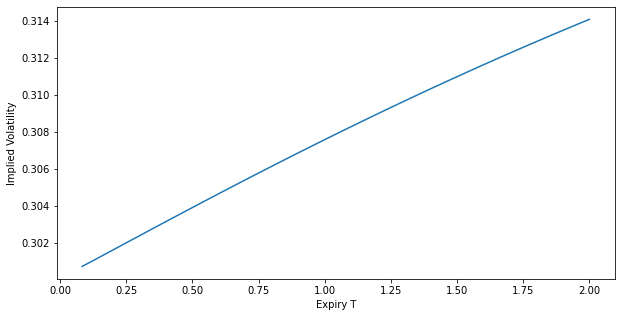

In [206]:
#alpha = 1.5
#K = 150
#T = 0.25
#r = 0.025
#S0 = 150
#n = 9
#B = 150 * 2.7
sigma = 0.2
Call_sigma = FFT(sigma, eta0, kappa, rho, theta, S0, r, T)
K_list = np.linspace(60, 260, 60)
price_list_sigma = [Call_sigma.Heston_fft(alpha, n, B, k)[0] for k in K_list]
vol_K(price_list_sigma, K_list, sigma, T, r, S0)  

T_list = np.linspace(1/12, 2, 50)
price_list = [FFT(sigma, eta0, kappa, rho, theta, S0, r, t).Heston_fft(alpha, n, B, K)[0] for t in T_list]
vol_T(price_list, T_list, sigma, r, K, S0)

## In comparison with the original plots, 
## new sigma = 0.2 
## In comparison with the original plots, the shape of volatility skew becomes flat, the term structure becomes increasing and moves up a bit.

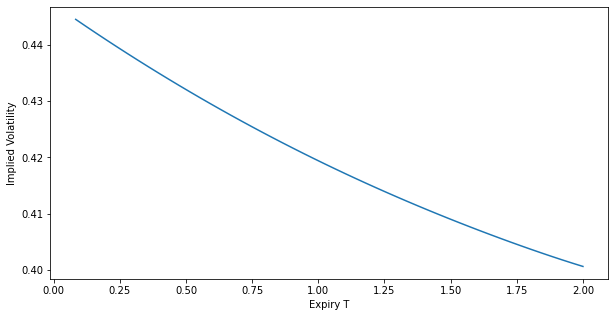

In [207]:
eta0 = 0.2
sigma = 0.4
Call_eta0 = FFT(sigma, eta0, kappa, rho, theta, S0, r, T)
K_list = np.linspace(60, 260, 60)
price_list_eta0 = [Call_eta0.Heston_fft(alpha, n, B, k)[0] for k in K_list]
vol_K(price_list_eta0, K_list, sigma, T, r, S0)  

T_list = np.linspace(1/12, 2, 50)
price_list = [FFT(sigma, eta0, kappa, rho, theta, S0, r, t).Heston_fft(alpha, n, B, K)[0] for t in T_list]
vol_T(price_list, T_list, sigma, r, K, S0)

## new eta0 = 0.2
## In comparison with the original plots, both curves move up, the term structure becomes decreasing, the range of implied volatility becomes wider.

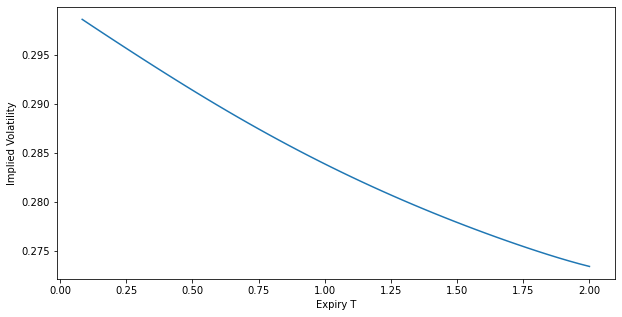

In [208]:
eta0 = 0.09
kappa = 0.1
Call_kappa = FFT(sigma, eta0, kappa, rho, theta, S0, r, T)
K_list = np.linspace(60, 260, 60)
price_list_kappa = [Call_kappa.Heston_fft(alpha, n, B, k)[0] for k in K_list]
vol_K(price_list_kappa, K_list, sigma, T, r, S0)  

T_list = np.linspace(1/12, 2, 50)
price_list = [FFT(sigma, eta0, kappa, rho, theta, S0, r, t).Heston_fft(alpha, n, B, K)[0] for t in T_list]
vol_T(price_list, T_list, sigma, r, K, S0)  

## new kappa = 0.1
## In comparison with the original plots, the volatility skew looks similar, but the term structure becomes decreasing and moves down a bit.

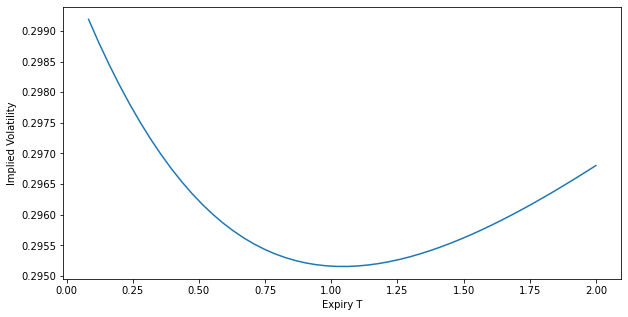

In [209]:
kappa = 0.5
rho = -0.25
Call_rho = FFT(sigma, eta0, kappa, rho, theta, S0, r, T)
K_list = np.linspace(60, 260, 60)
price_list_rho = [Call_rho.Heston_fft(alpha, n, B, k)[0] for k in K_list]
vol_K(price_list_rho, K_list, sigma, T, r, S0)  

T_list = np.linspace(1/12, 2, 50)
price_list = [FFT(sigma, eta0, kappa, rho, theta, S0, r, t).Heston_fft(alpha, n, B, K)[0] for t in T_list]
vol_T(price_list, T_list, sigma, r, K, S0)

## new rho = -0.25
## In comparison with the original plots, the volatility skew moves right, the term structure curve moves down.

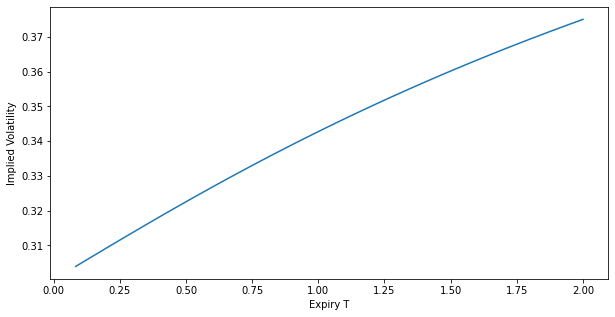

In [210]:
rho = 0.25
theta = 0.25
Call_theta = FFT(sigma, eta0, kappa, rho, theta, S0, r, T)
K_list = np.linspace(60, 260, 60)
price_list_theta = [Call_theta.Heston_fft(alpha, n, B, k)[0] for k in K_list]
vol_K(price_list_theta, K_list, sigma, T, r, S0)  

T_list = np.linspace(1/12, 2, 50)
price_list = [FFT(sigma, eta0, kappa, rho, theta, S0, r, t).Heston_fft(alpha, n, B, K)[0] for t in T_list]
vol_T(price_list, T_list, sigma, r, K, S0)

## new theta = 0.25
## In comparison with the original plots, the volatility skew move up a bit, the shape looks similar. The term structure becomes increasing and moves up.